In [ ]:
# Data Source: https://realestate.co.jp/en/rent

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# Set seaborn style and ignore warnings
sns.set(color_codes=True)
warnings.filterwarnings("ignore")

# **1. Importing Data**

In [ ]:
url = 'https://raw.githubusercontent.com/coco2525/tokyo-rental-forecasting/refs/heads/main/data/sample_rental_prices_tokyo.csv'
data = pd.read_csv(url)

In [ ]:
data.head()

,room_type,category,street,city,prefecture,cost,size,deposit,key_money,floor,year,station,minute
0,2LDK,Apartment,Shinjuku,Shinjuku-ku,Tokyo,552000.0,84.75,1104000.0,0.0,9.0,2011,Higashi-Shinjuku,2.0
1,1R,Apartment,Daizawa,Setagaya-ku,Tokyo,59000.0,15.28,0.0,0.0,1.0,1969,Ikenoue,8.0
2,1K,Apartment,Soshigaya,Setagaya-ku,Tokyo,63000.0,17.00,0.0,0.0,2.0,1996,Soshigaya Okura,7.0
3,1R,Apartment,Daita,Setagaya-ku,Tokyo,58000.0,11.40,55000.0,0.0,2.0,1989,Shindaita,2.0
4,1LDK,Apartment,Seijo,Setagaya-ku,Tokyo,212000.0,43.33,0.0,0.0,3.0,2023,Seijougakuen Mae,7.0


# **2. Data Cleaning**

In [ ]:
# Display data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   room_type   776 non-null    object 
 1   category    776 non-null    object 
 2   street      776 non-null    object 
 3   city        776 non-null    object 
 4   prefecture  776 non-null    object 
 5   cost        776 non-null    float64
 6   size        776 non-null    float64
 7   deposit     776 non-null    float64
 8   key_money   776 non-null    float64
 9   floor       711 non-null    float64
 10  year        776 non-null    int64  
 11  station     737 non-null    object 
 12  minute      737 non-null    float64
dtypes: float64(6), int64(1), object(6)
memory usage: 78.9+ KB


In [ ]:
# Count columns with blank values
print("Number of missing values:\n", data.isnull().sum())

Number of missing values:
 room_type      0
category       0
street         0
city           0
prefecture     0
cost           0
size           0
deposit        0
key_money      0
floor         65
year           0
station       39
minute        39
dtype: int64


In [ ]:
# Calculate and display percentage of missing values
print("Percentage of missing values:\n", data.isnull().sum() * 100 / len(data))

Percentage of missing values:
 room_type     0.000000
category      0.000000
street        0.000000
city          0.000000
prefecture    0.000000
cost          0.000000
size          0.000000
deposit       0.000000
key_money     0.000000
floor         8.376289
year          0.000000
station       5.025773
minute        5.025773
dtype: float64


In [ ]:
# Drop rows with missing values
data_dropped = data.dropna(axis=0, how='any')

In [ ]:
# Filter apartments and drop unnecessary columns
filter_apartment = data_dropped['category'] == 'Apartment'
df = data_dropped[filter_apartment]
df = df.drop(columns=['street', 'city', 'category', 'prefecture', 'deposit', 'key_money'])
df.head()

,room_type,cost,size,floor,year,station,minute
0,2LDK,552000.0,84.75,9.0,2011,Higashi-Shinjuku,2.0
1,1R,59000.0,15.28,1.0,1969,Ikenoue,8.0
2,1K,63000.0,17.00,2.0,1996,Soshigaya Okura,7.0
3,1R,58000.0,11.40,2.0,1989,Shindaita,2.0
4,1LDK,212000.0,43.33,3.0,2023,Seijougakuen Mae,7.0


# **3. Data Preprocessing**

In [ ]:
# Apply lower case conversion to the 'station' column
df['station'] = df['station'].apply(lambda s: s.lower() if type(s) == str else s)
# Replace '-' with ' ' and 'yoyogiuehara' with 'yoyogi uehara'
df['station'] = df['station'].str.replace('-', ' ').replace('yoyogiuehara', 'yoyogi uehara')

In [ ]:
# Create new columns for room type details
df['has_DK'] = 0
df['has_K'] = 0
df['has_L'] = 0
df['has_S'] = 0

In [ ]:
df = df.reset_index(drop=True)
# Iterate over each row to fill in the details
for x in range(len(df)):
    if 'DK' in df['room_type'][x]:
        df.loc[x, 'has_DK'] = 1
    df.loc[x, 'room_type'] = df.loc[x, 'room_type'].replace('DK', '')

    if 'K' in df['room_type'][x]:
        df.loc[x, 'has_K'] = 1
    df.loc[x, 'room_type'] = df.loc[x, 'room_type'].replace('K', '')

    if 'L' in df['room_type'][x]:
        df.loc[x, 'has_L'] = 1
    df.loc[x, 'room_type'] = df.loc[x, 'room_type'].replace('L', '')

    if 'S' in df['room_type'][x]:
        df.loc[x, 'has_S'] = 1
    df.loc[x, 'room_type'] = df.loc[x, 'room_type'].replace('S', '')

# Convert the remaining room_type values to numeric
df['num_rooms'] = df['room_type'].str.extract('(\d+)').astype(int)
#Resource: https://qiita.com/Tusnori/items/31746dd1c55ecff2bb22

In [ ]:
# Drop the original room_type column
df.drop(columns=['room_type'], inplace=True)

In [ ]:
# Calculate building age
current_year = datetime.datetime.now().year
df['building_age'] = current_year - df['year']

# Drop the original year column
df.drop(columns=['year'], inplace=True)

# **4. Filtering Relevant Data**

In [ ]:
# Filter stations on the Odakyu line
odakyu_stations = [
    'shinjuku', 'minami shinjuku', 'sangubashi', 'yoyogi hachiman', 'yoyogi uehara', 'higashikitazawa', 'shimokitazawa',
    'setagaya daita', 'umegaoka', 'goutokuji', 'kyoudou', 'chitosefunabashi', 'soshigaya okura', 'seijougakuen mae', 'kitami',
    'komae', 'izumitamagawa', 'tsurukawa', 'tamagawagakuen mae', 'machida'
]

In [ ]:
# Check how many stations are not on the Odakyu line
print("Number of stations not on the Odakyu line:", df[~df['station'].isin(odakyu_stations)].shape[0])

Number of stations not on the Odakyu line: 273


In [ ]:
# Filter the dataframe to include only stations on the Odakyu line
df_odakyu = df[df['station'].isin(odakyu_stations)]

In [ ]:
# Detect outliers
Q1 = df_odakyu['cost'].quantile(0.25)
Q3 = df_odakyu['cost'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df_odakyu['cost'] < (Q1 - 1.5 * IQR)) | (df_odakyu['cost'] > (Q3 + 1.5 * IQR))).sum()
print("Number of outliers:", outliers)

Number of outliers: 18


In [ ]:
# Filter out the outliers
df_odakyu = df_odakyu[(df_odakyu['cost'] >= (Q1 - 1.5 * IQR)) & (df_odakyu['cost'] <= (Q3 + 1.5 * IQR))]
df_odakyu

,cost,size,floor,station,minute,has_DK,has_K,has_L,has_S,num_rooms,building_age
2,63000.0,17.00,2.0,soshigaya okura,7.0,0,1,0,0,1,28
4,212000.0,43.33,3.0,seijougakuen mae,7.0,1,0,1,0,1,1
5,48000.0,19.50,3.0,komae,9.0,0,1,0,0,1,36
7,91000.0,20.72,3.0,chitosefunabashi,9.0,0,0,0,0,1,32
8,63000.0,17.00,2.0,soshigaya okura,6.0,0,1,0,0,1,28
...,...,...,...,...,...,...,...,...,...,...,...
685,102000.0,27.65,2.0,yoyogi hachiman,10.0,0,1,0,0,1,21
686,67000.0,18.63,2.0,setagaya daita,4.0,0,1,0,0,1,39
687,65000.0,17.42,2.0,setagaya daita,4.0,0,0,0,0,1,38
688,122000.0,31.80,2.0,yoyogi hachiman,10.0,1,0,0,0,1,21


In [ ]:
# Encode 'station' column
station_encorded = pd.get_dummies(df_odakyu['station'])
df_odakyu_encoded = pd.concat([df_odakyu, station_encorded], axis=1)
df_odakyu_encoded.drop(columns=['station'], inplace=True)
df_odakyu_encoded = df_odakyu_encoded[['num_rooms', 'has_DK', 'has_K', 'has_L', 'has_S', 'building_age', 'floor', 'size', 'minute', 'cost', 'shinjuku', 'minami shinjuku', 'sangubashi', 'yoyogi hachiman', 'yoyogi uehara', 'higashikitazawa', 'shimokitazawa',
    'setagaya daita', 'umegaoka', 'goutokuji', 'kyoudou', 'chitosefunabashi', 'soshigaya okura', 'seijougakuen mae', 'kitami',
    'komae', 'izumitamagawa', 'tsurukawa', 'tamagawagakuen mae', 'machida']]
df_odakyu_encoded.head()

,num_rooms,has_DK,has_K,has_L,has_S,building_age,floor,size,minute,cost,...,kyoudou,chitosefunabashi,soshigaya okura,seijougakuen mae,kitami,komae,izumitamagawa,tsurukawa,tamagawagakuen mae,machida
2,1,0,1,0,0,28,2.0,17.00,7.0,63000.0,...,False,False,True,False,False,False,False,False,False,False
4,1,1,0,1,0,1,3.0,43.33,7.0,212000.0,...,False,False,False,True,False,False,False,False,False,False
5,1,0,1,0,0,36,3.0,19.50,9.0,48000.0,...,False,False,False,False,False,True,False,False,False,False
7,1,0,0,0,0,32,3.0,20.72,9.0,91000.0,...,False,True,False,False,False,False,False,False,False,False
8,1,0,1,0,0,28,2.0,17.00,6.0,63000.0,...,False,False,True,False,False,False,False,False,False,False


# **5. Data Visualization**

In [ ]:
# Set the size of all graphs
sns.set(rc={'figure.figsize':(12, 8)})

In [ ]:
# Calculate the sum of each dummy station column
station_counts = station_encorded.sum().sort_values(ascending=False)

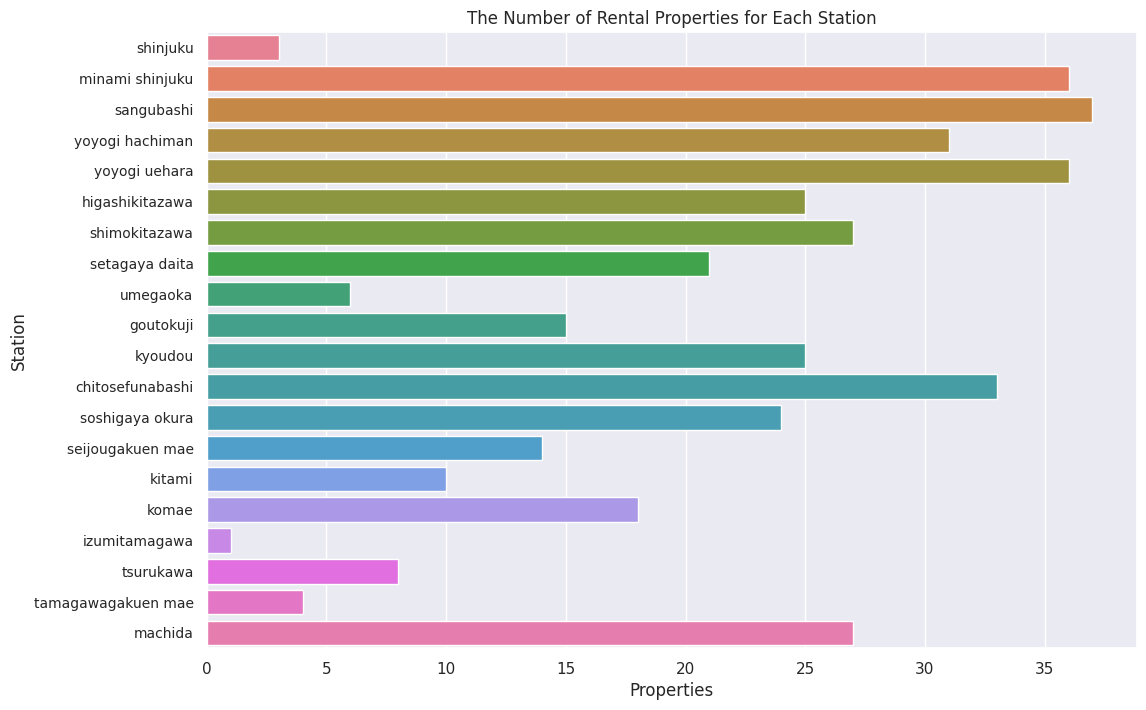

In [ ]:
# Count the number of entries in each 'station' category
sns.barplot(x=station_counts.values, y=station_counts.index, palette='husl', order=odakyu_stations)
plt.title('The Number of Rental Properties for Each Station')
plt.xlabel('Properties')
plt.ylabel('Station')

# Adjust the y-axis label spacing and fontsize
plt.yticks(fontsize=10)
plt.show()

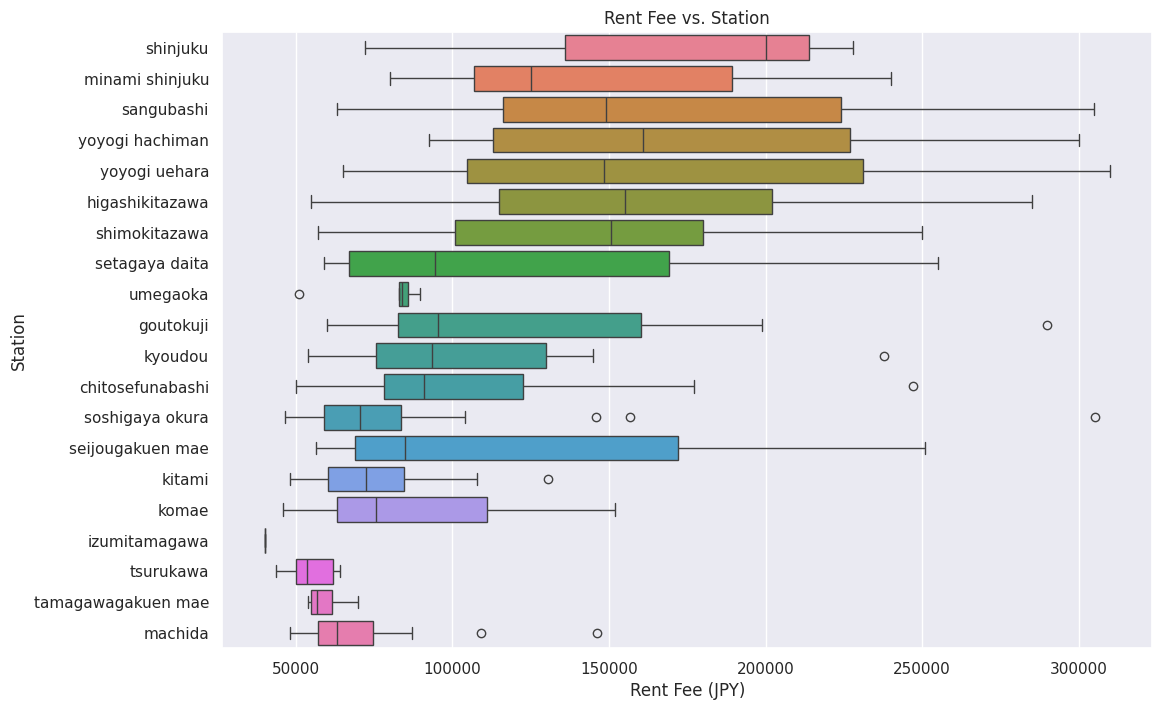

In [ ]:
# Plot the boxplot
sns.boxplot(x='cost', y='station', palette='husl', data=df_odakyu, order=odakyu_stations).set(title='Rent Fee vs. Station')
plt.xlabel('Rent Fee (JPY)')
plt.ylabel('Station')
plt.show()

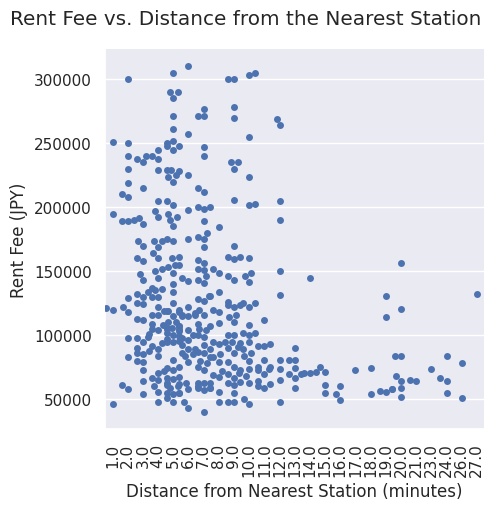

In [ ]:
# Factor Plot
rp = sns.catplot(x='minute', y='cost', data=df_odakyu, kind='swarm')
rp.fig.subplots_adjust(top=0.9)  # Adjust the figure
rp.set_xticklabels(rotation=90)
rp.fig.suptitle('Rent Fee vs. Distance from the Nearest Station')
plt.xlabel('Distance from Nearest Station (minutes)')
plt.ylabel('Rent Fee (JPY)')
plt.show()

In [ ]:
# Generate correlation matrix
corr = df_odakyu_encoded[['num_rooms', 'has_DK', 'has_K', 'has_L', 'has_S', 'building_age', 'floor', 'size', 'minute']].corr()

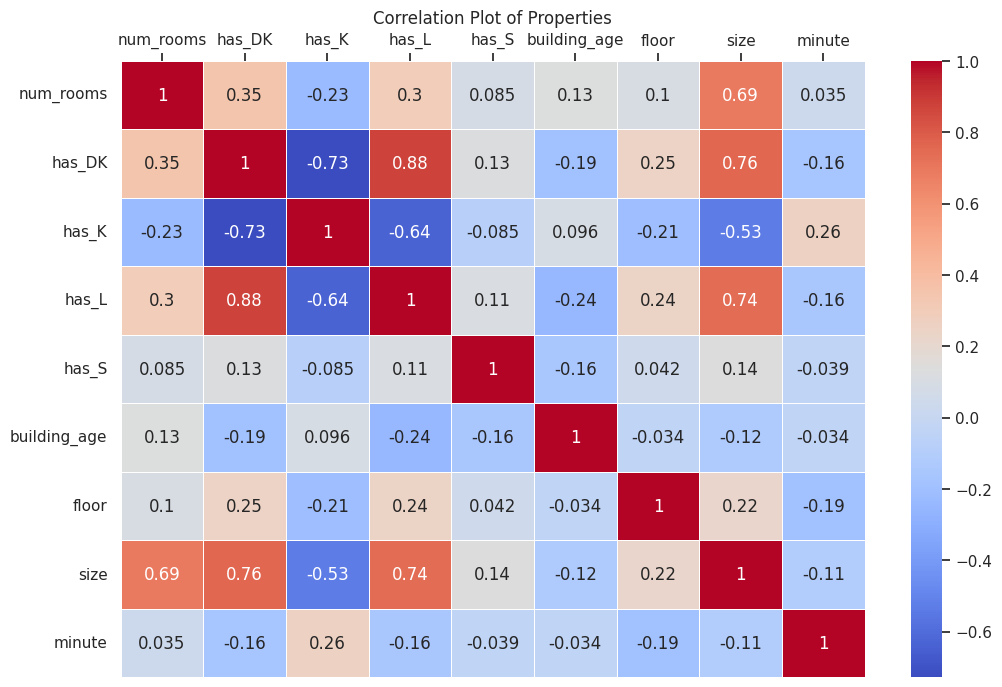

In [ ]:
# Heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidth=0.5).set(title='Correlation Plot of Properties')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.show()

# **6. Feature Selection and Splitting Data**

In [ ]:
# Define target variable (y)
y = df_odakyu_encoded['cost'].values

In [ ]:
# Remove unnecessary variables
df_cleaned = df_odakyu_encoded.drop(columns=['num_rooms', 'has_DK', 'has_S', 'cost'])

In [ ]:
df_cleaned

,has_K,has_L,building_age,floor,size,minute,shinjuku,minami shinjuku,sangubashi,yoyogi hachiman,...,kyoudou,chitosefunabashi,soshigaya okura,seijougakuen mae,kitami,komae,izumitamagawa,tsurukawa,tamagawagakuen mae,machida
2,1,0,28,2.0,17.00,7.0,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,0,1,1,3.0,43.33,7.0,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
5,1,0,36,3.0,19.50,9.0,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
7,0,0,32,3.0,20.72,9.0,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
8,1,0,28,2.0,17.00,6.0,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,0,21,2.0,27.65,10.0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
686,1,0,39,2.0,18.63,4.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
687,0,0,38,2.0,17.42,4.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
688,0,0,21,2.0,31.80,10.0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Create a new dataframe for features (X)
X = df_cleaned.values

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# **7. Standardization**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **8. Fitting the model to the training data**

In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

# **9. Making Predictions**

In [ ]:
y_pred = model.predict(X_test_scaled)

# **10. Model Assessment**

In [ ]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

R2: 0.8546674636115343
MSE: 561965418.3643129
RMSE: 23705.809801909592
MAE: 18123.36327858679


# **11. Visualization of Actual vs Predicted Values**

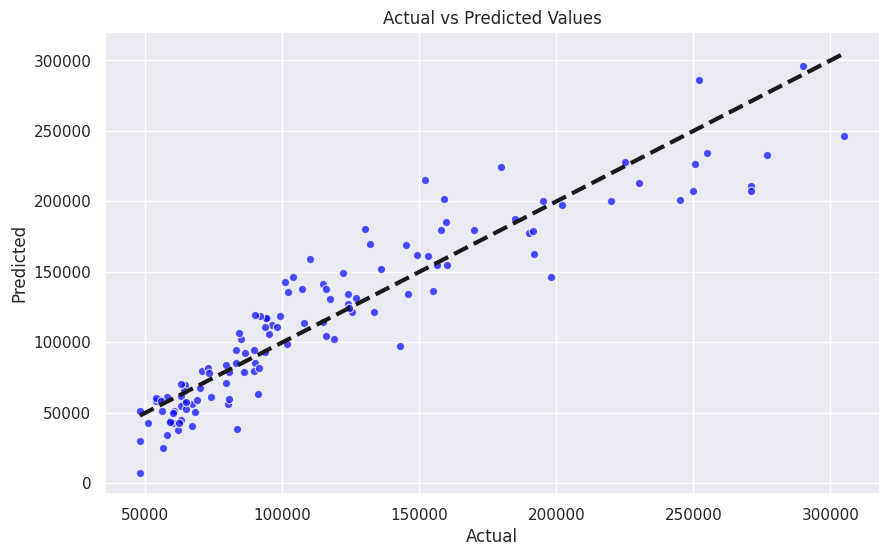

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color ='blue', edgecolor='w', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

# **12. Save the Model and Scaler**

In [ ]:
model_filename = 'tokyo_odakyu_line_rent_linear_regression_model.pkl'
scaler_filename = 'scaler.pkl'

with open(model_filename, 'wb') as model_file:
  pickle.dump(model, model_file)

with open(scaler_filename, 'wb') as scaler_file:
  pickle.dump(scaler, scaler_file)